In [1]:
import random
from random import sample
import argparse
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
# from skimage import morphology
# from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
# import datasets.mvtec as mvtec
import datasets.bowtie as bowtie

# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device:', device)


Device: cuda


In [2]:
def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return x


def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

def plot_fig(test_img, scores, img_scores, save_dir, class_name):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    for i in range(num):
        img = test_img[i]
        img = denormalization(img)
        heat_map = scores[i] * 255
        
        fig_img, ax_img = plt.subplots(1, 3, figsize=(12, 4))
        fig_img.subplots_adjust(right=0.9)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
            
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        
        ax = ax_img[1].imshow(heat_map, cmap='jet', norm=norm)
        ax_img[1].imshow(img, cmap='gray', interpolation='none')
        ax_img[1].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[1].title.set_text('Predicted heat map')
        
        # Add a placeholder for segmentation result and anomaly score
        ax_img[2].imshow(img)
        ax_img[2].title.set_text('Segmentation result')
        ax_img[2].text(5, 20, f'Anomaly Score: {img_scores[i]:.3f}', color='white', backgroundcolor='black')


        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)

        fig_img.savefig(os.path.join(save_dir, class_name + '_{}'.format(i)), dpi=100)
        plt.close()
        
# A helper function to show images
def show_image(tensor_img):
    img_to_show = tensor_img.numpy().transpose(1, 2, 0)
    # Denormalize for viewing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_to_show = std * img_to_show + mean
    img_to_show = np.clip(img_to_show, 0, 1)
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()



In [3]:
arch = "wide_resnet50_2"
data_path = "../anomaly_detection/data/BowTie-New/original"
save_path = "./results/bowtie"

class_name = "116"

In [4]:
# model = resnet18(pretrained=True, progress=True)
# t_d = 448
# d = 100

model = wide_resnet50_2(pretrained=True, progress=True)
t_d = 1792
d = 550

model.to(device)
model.eval()
random.seed(1024)
torch.manual_seed(1024)
if use_cuda:
    torch.cuda.manual_seed_all(1024)

idx = torch.tensor(sample(range(0, t_d), d))

outputs = []

def hook(module, input, output):
    outputs.append(output)

model.layer1[-1].register_forward_hook(hook)
model.layer2[-1].register_forward_hook(hook)
model.layer3[-1].register_forward_hook(hook)

os.makedirs(os.path.join(save_path, 'temp_%s' % arch), exist_ok=True)

/home/mikeszklarz/anaconda3/envs/padim/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mikeszklarz/anaconda3/envs/padim/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
total_roc_auc = []

train_dataset = bowtie.BowtieDataset(data_path, class_name=class_name, is_train=True, resize=512, cropsize=400)
train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
test_dataset = bowtie.BowtieDataset(data_path, class_name=class_name, is_train=False, resize=512, cropsize=400)
test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

Sampling 25 normal images from training set for testing.


In [7]:
train_feature_filepath = os.path.join(save_path, 'temp_%s' % arch, 'train_%s.pkl' % class_name)
if not os.path.exists(train_feature_filepath):
    for (x, _, _) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
        with torch.no_grad():
            _ = model(x.to(device))
        for k, v in zip(train_outputs.keys(), outputs):
            train_outputs[k].append(v.cpu().detach())
        outputs = []
    for k, v in train_outputs.items():
        train_outputs[k] = torch.cat(v, 0)

    embedding_vectors = train_outputs['layer1']
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = embedding_concat(embedding_vectors, train_outputs[layer_name])

    embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
    B, C, H, W = embedding_vectors.size()
    embedding_vectors = embedding_vectors.view(B, C, H * W)
    mean = torch.mean(embedding_vectors, dim=0).numpy()
    cov = torch.zeros(C, C, H * W).numpy()
    I = np.identity(C)
    for i in range(H * W):
        cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
    train_outputs = [mean, cov]
    with open(train_feature_filepath, 'wb') as f:
        pickle.dump(train_outputs, f)
else:
    print('load train set feature from: %s' % train_feature_filepath)
    with open(train_feature_filepath, 'rb') as f:
        train_outputs = pickle.load(f)


| feature extraction | train | 116 |: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Input Image Tensor Shape: torch.Size([3, 400, 400])


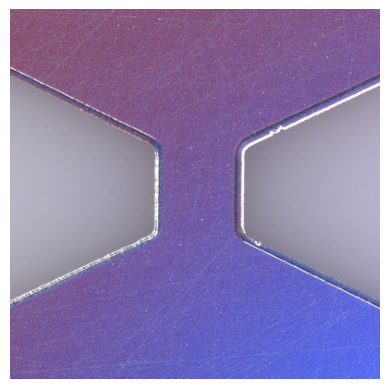

In [8]:
# Get one sample image from the training set
sample_img, _, _ = train_dataset[0]

print("Input Image Tensor Shape:", sample_img.shape)
show_image(sample_img)

Layer 1 Feature Map Shape: torch.Size([1, 256, 100, 100])
Layer 2 Feature Map Shape: torch.Size([1, 512, 50, 50])
Layer 3 Feature Map Shape: torch.Size([1, 1024, 25, 25])


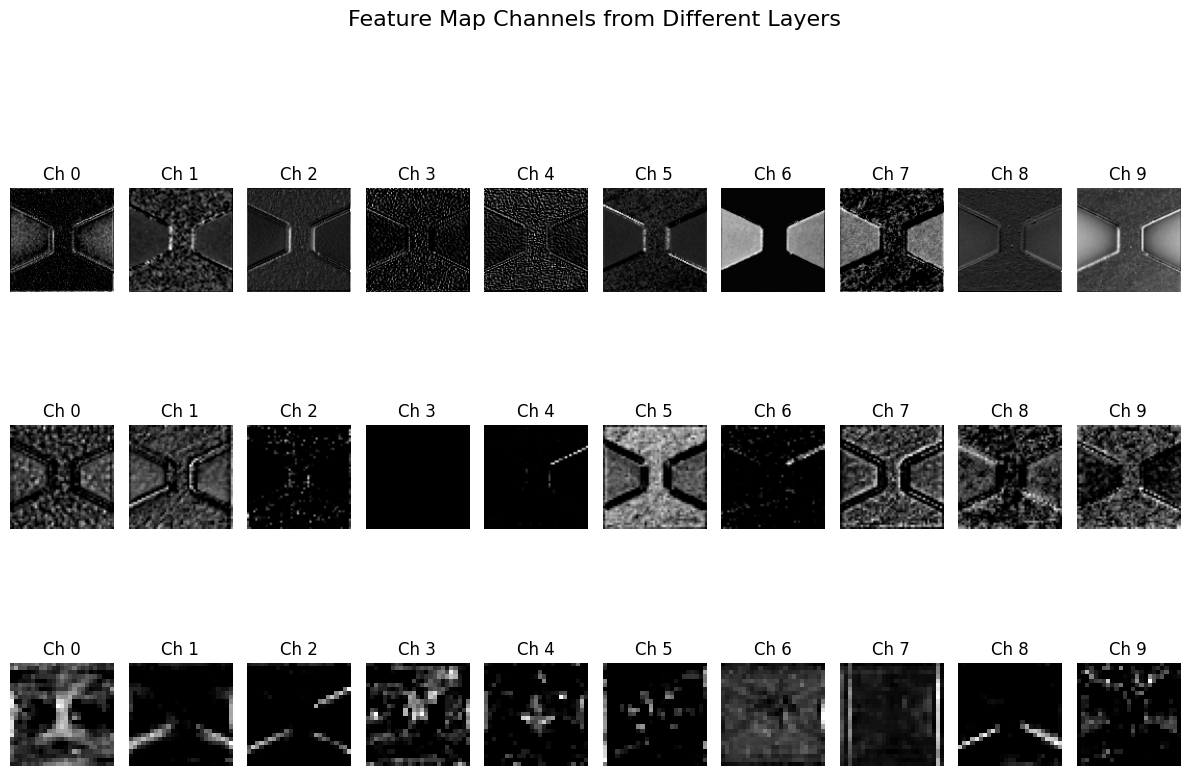

In [9]:
# %% Visualize the extracted feature maps from the hooks

# We need to add a batch dimension for the model
sample_img_batch = sample_img.unsqueeze(0).to(device)

# Pass the image through the model
with torch.no_grad():
    _ = model(sample_img_batch) # The hooks will capture the outputs

# 'outputs' now contains the feature maps from layer1, layer2, and layer3
feature_map_l1, feature_map_l2, feature_map_l3 = outputs

print("Layer 1 Feature Map Shape:", feature_map_l1.shape)
print("Layer 2 Feature Map Shape:", feature_map_l2.shape)
print("Layer 3 Feature Map Shape:", feature_map_l3.shape)

# Clear the outputs list for the next steps
outputs = []

n = 10

# Plot a few channels from each feature map
fig, axes = plt.subplots(3, n, figsize=(12, 9))
fig.suptitle("Feature Map Channels from Different Layers", fontsize=16)

for i in range(n):
    # Layer 1
    axes[0, i].imshow(feature_map_l1[0, i].cpu().numpy(), cmap='gray')
    axes[0, i].set_title(f'Ch {i}')
    axes[0, i].axis('off')
    
    # Layer 2
    axes[1, i].imshow(feature_map_l2[0, i].cpu().numpy(), cmap='gray')
    axes[1, i].set_title(f'Ch {i}')
    axes[1, i].axis('off')
    
    # Layer 3
    axes[2, i].imshow(feature_map_l3[0, i].cpu().numpy(), cmap='gray')
    axes[2, i].set_title(f'Ch {i}')
    axes[2, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

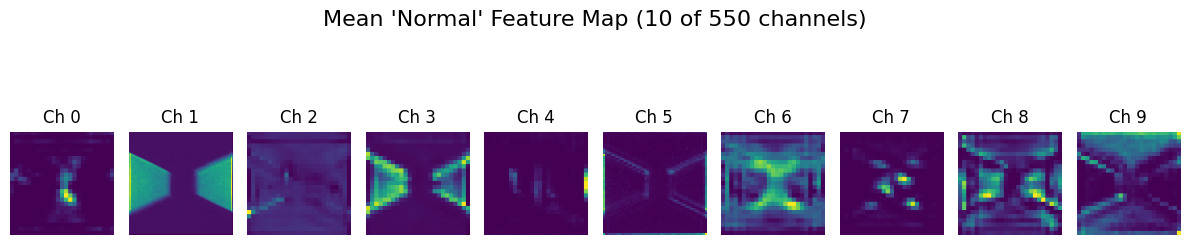

In [10]:
# %% Visualize the mean "normal" feature map
mean_features = train_outputs[0] # Shape [550, 10000]

# Reshape to be plottable
mean_features_map = mean_features.reshape(550, 100, 100)

n = 10

# Plot a few channels of the mean feature map
fig, axes = plt.subplots(1, n, figsize=(12, 3))
fig.suptitle(f"Mean 'Normal' Feature Map ({n} of 550 channels)", fontsize=16)
for i in range(n):
    axes[i].imshow(mean_features_map[i], cmap='viridis')
    axes[i].set_title(f'Ch {i}')
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [11]:
gt_list = []
test_imgs = []

for (x, y, _) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
    test_imgs.extend(x.cpu().detach().numpy())
    gt_list.extend(y.cpu().detach().numpy())
    with torch.no_grad():
        _ = model(x.to(device))
    for k, v in zip(test_outputs.keys(), outputs):
        test_outputs[k].append(v.cpu().detach())
    outputs = []

| feature extraction | test | 116 |: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


In [12]:
for k, v in test_outputs.items():
    test_outputs[k] = torch.cat(v, 0)

In [13]:
embedding_vectors = test_outputs['layer1']
for layer_name in ['layer2', 'layer3']:
    embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

In [14]:
# embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
# B, C, H, W = embedding_vectors.size()
# embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
# dist_list = []
# for i in range(H * W):
#     mean = train_outputs[0][:, i]
#     conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
#     dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
#     dist_list.append(dist)

In [15]:
embedding_vectors = torch.index_select(embedding_vectors, 1, idx).to(device)
B, C, H, W = embedding_vectors.size()
embedding_vectors = embedding_vectors.view(B, C, H * W)

dist_list = []
mean = torch.tensor(train_outputs[0], device=device)  # [C, H*W]
cov = torch.tensor(train_outputs[1], device=device)   # [C, C, H*W]
I = torch.eye(C, device=device)

for i in range(H * W):
    mean_i = mean[:, i]
    cov_i = cov[:, :, i]
    cov_inv = torch.linalg.inv(cov_i)
    samples = embedding_vectors[:, :, i]  # [B, C]
    diff = samples - mean_i
    # Mahalanobis distance: sqrt((x - mean)^T @ cov_inv @ (x - mean))
    dist = torch.sqrt(torch.einsum('bi,ij,bj->b', diff, cov_inv, diff))
    dist_list.append(dist.cpu().numpy())  # Move to CPU for later processing

# dist_list shape: [H*W, B]

In [16]:
dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)
dist_list = torch.tensor(dist_list)
score_map = F.interpolate(dist_list.unsqueeze(1), size=x.size(2), mode='bilinear',
                            align_corners=False).squeeze().numpy()

In [17]:
for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4)

In [18]:
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)

In [19]:
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(gt_list)
fpr, tpr, _ = roc_curve(gt_list, img_scores)
img_roc_auc = roc_auc_score(gt_list, img_scores)
total_roc_auc.append(img_roc_auc)

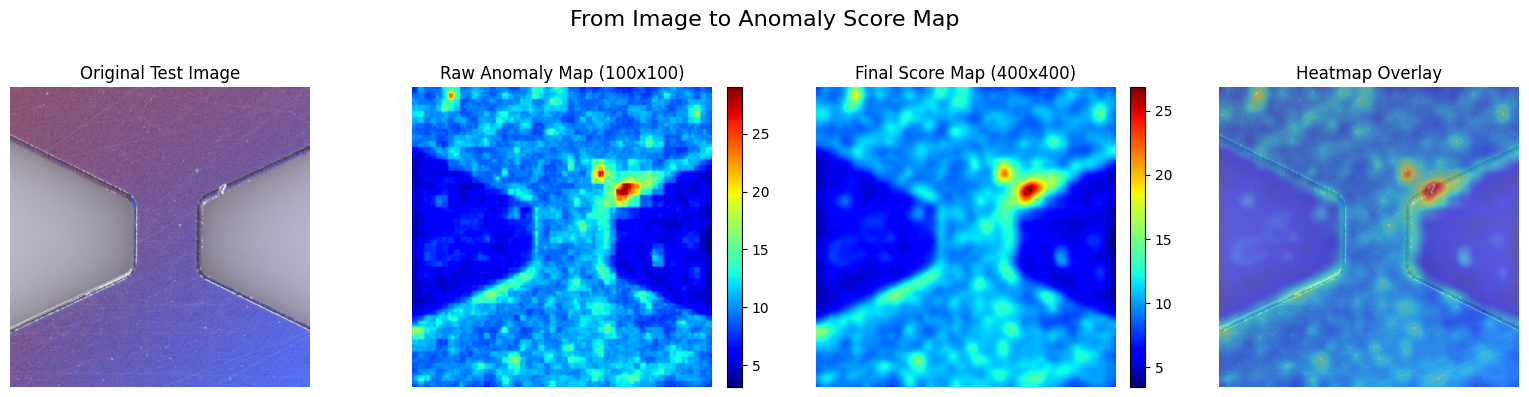

In [20]:
# %% Visualize the Anomaly Map Generation
# The 'dist_list' variable holds the anomaly map before upsampling
# Its shape is [Batch, Height, Width], e.g., [32, 100, 100]

# Let's look at the first image in the batch
raw_anomaly_map = dist_list[0] 

# The 'score_map' variable holds the upsampled and smoothed map
final_anomaly_map = score_map[0]

# Get the original test image for comparison
original_test_image = test_imgs[0]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("From Image to Anomaly Score Map", fontsize=16)

# 1. Original Test Image
axes[0].imshow(denormalization(original_test_image))
axes[0].set_title("Original Test Image")
axes[0].axis('off')

# 2. Raw Anomaly Map
im1 = axes[1].imshow(raw_anomaly_map, cmap='jet')
axes[1].set_title("Raw Anomaly Map (100x100)")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 3. Smoothed & Upsampled Anomaly Map
im2 = axes[2].imshow(final_anomaly_map, cmap='jet')
axes[2].set_title("Final Score Map (400x400)")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# 4. Heatmap Overlay
axes[3].imshow(denormalization(original_test_image))
axes[3].imshow(final_anomaly_map, cmap='jet', alpha=0.5)
axes[3].set_title("Heatmap Overlay")
axes[3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

image ROCAUC: 1.000


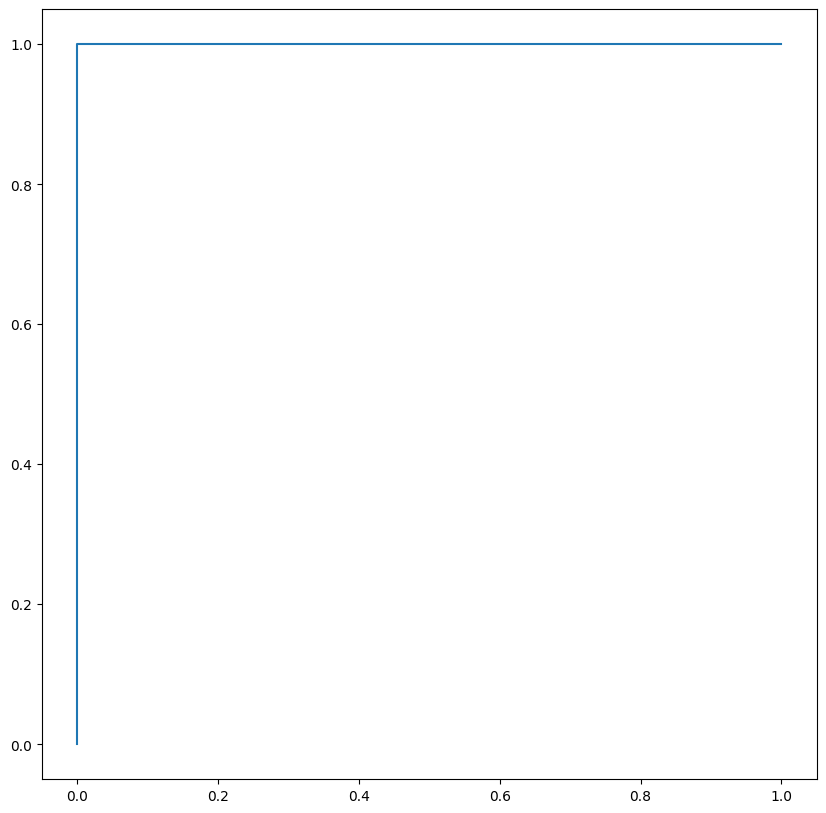

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig_img_rocauc = ax

print('image ROCAUC: %.3f' % (img_roc_auc))
fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))

save_dir = save_path + '/' + f'pictures_{arch}'
os.makedirs(save_dir, exist_ok=True)
plot_fig(test_imgs, scores, img_scores, save_dir, class_name)